Start Query
End Query
Processing Data


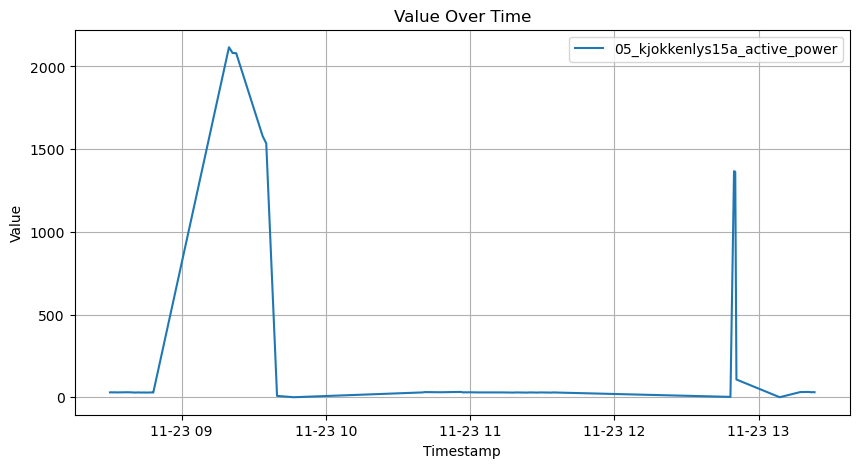

In [1]:
from influxdb_client import InfluxDBClient
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Connection settings
username = "homeassistant"
password = "homeassistant"
influx_host = "http://192.168.188.74:8086"
token = f"{username}:{password}"
org = "-" 
database_name = "homeassistantdb"

# Initialize client
client = InfluxDBClient(
    url=influx_host,
    token=token,
    org=org
)

results = []
fuse = "05_kjokkenlys15a_active_power"
# Edit range to increase or decrease from what time you want to gather data
flux_query = f'''
    from(bucket: "{database_name}/autogen")
      |> range(start: -5h)
      |> filter(fn: (r) => r._measurement == "W" and r._field == "value")
      |> filter(fn: (r) => r.entity_id == "{fuse}")
      '''

print("Start Query")
    
try:
    result = client.query_api().query(query=flux_query)
    for table in result:
        for record in table.records:
            results.append(record)  
    
except Exception as e:
        print("An error occurred:", e)
        
print("End Query")
print("Processing Data")
    
structured_data = []

for record in results:
    field = record.values.get('_field') 
    value = record.values.get('_value')  
    measurement = record.values.get('_measurement')
    timestamp = record.values.get('_time')
    entity_id = record.values.get('entity_id')
    domain = record.values.get('domain')

    # Append only if all required fields exist
    if field and value and timestamp:
        structured_data.append({
            'field': field,
            'value': value,
            'measurement': measurement,
            'timestamp': timestamp,
            'entity_id': entity_id,
            'domain': domain
        })


# Convert the flattened structured data to a pandas DataFrame
df = pd.DataFrame(structured_data)

# Filter and sort the data as needed
df_cleaned = df[df['value'] != 'power'] # Sometimes value = 'power', we remove these occurences
df_cleaned = df_cleaned.sort_values(by='timestamp', ascending=True) #Make sure the dataset is sorted by the timestamp
df_cleaned.head()

df_cleaned.to_csv("datatest.csv")# Convert the dataframe to a csv file for archiving and further usage

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(df_cleaned['timestamp'], df_cleaned['value'], label=f'{fuse}')
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.title("Value Over Time")
plt.legend()
plt.grid(True)
plt.show()


